# Sentiment Analysis Project

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

The goal of this project is to analyze the data and develop an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarize the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower the financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.2 MB/s eta 0:00:00


In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm.autonotebook import tqdm, trange
# from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [5]:
stock_news = pd.read_csv('stock_news.csv', parse_dates=['Date'])

In [6]:
df = stock_news.copy()

## **Data Overview**

In [7]:
df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


## **Exploratory Data Analysis**

The stock price fluctuates within a defined range, showing periodic peaks and drops. Significant price jumps appear to align with specific dates.

High trading volume aligned with sharp stock price movements. A sudden drop in price with increased volume suggests potential panic selling after negative sentiment. Conversely, price surges with volume spikes likely correspond to positive sentiment-driven buying behavior.

A large proportion of neutral sentiment suggests that most news articles may not have strong biases.

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

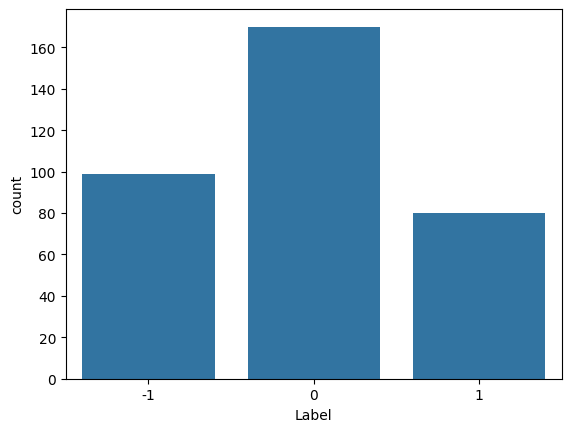

In [11]:
sns.countplot(data=df, x="Label");

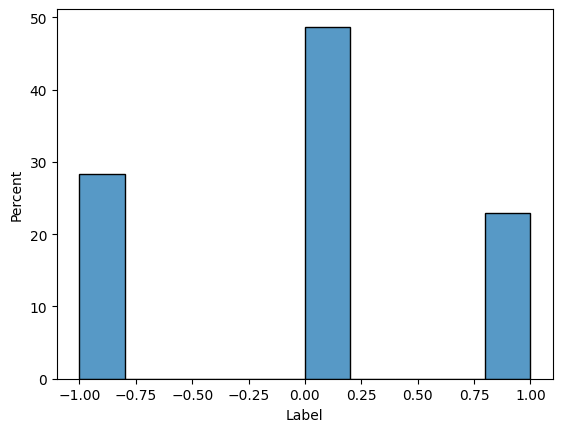

In [12]:
sns.histplot(data=df, x="Label", stat="percent");

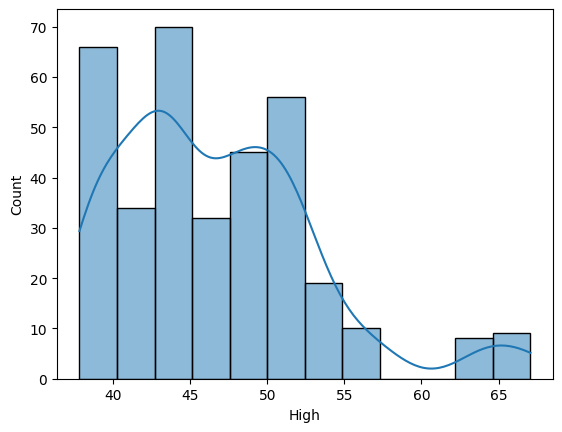

In [13]:
sns.histplot(data=df, x="High", kde=True);

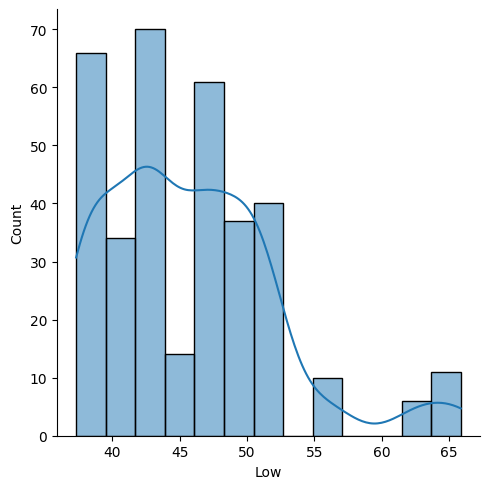

In [14]:
sns.displot(data=df, x="Low", kde=True);

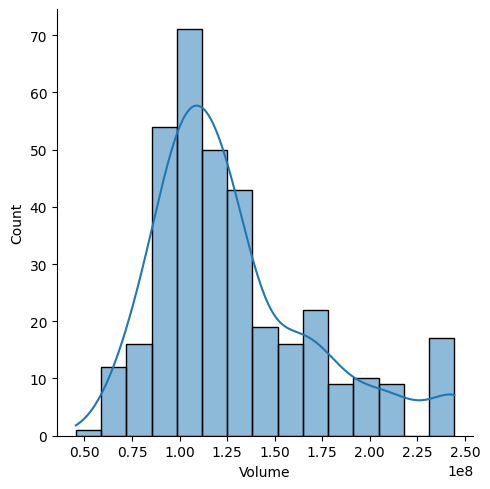

In [15]:
sns.displot(data=df, x="Volume", kde=True);

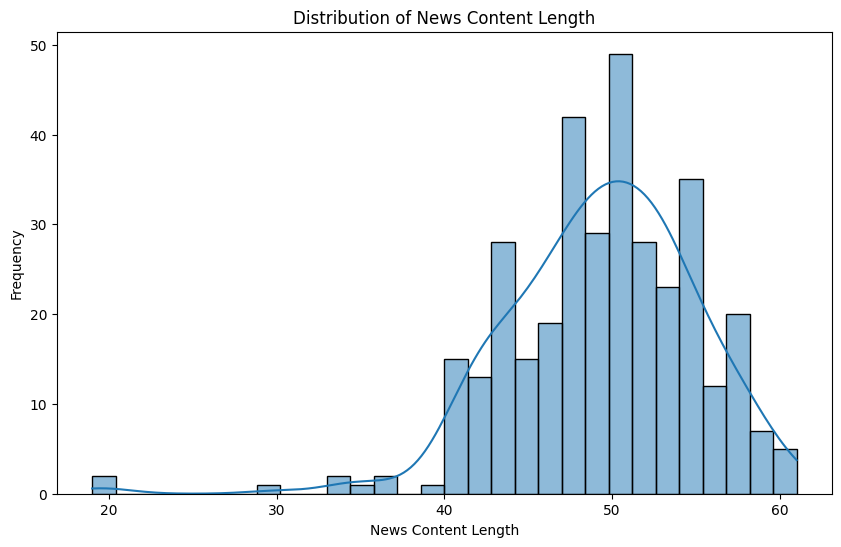

In [16]:
# Compute and check the distribution of the length of news content
df['NewsLength'] = df['News'].apply(lambda x: len(x.split(' ')))

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['NewsLength'], bins=30, kde=True)
plt.xlabel("News Content Length")
plt.ylabel("Frequency")
plt.title("Distribution of News Content Length")
plt.show();

In [17]:
df['NewsLength'].describe()

,NewsLength
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

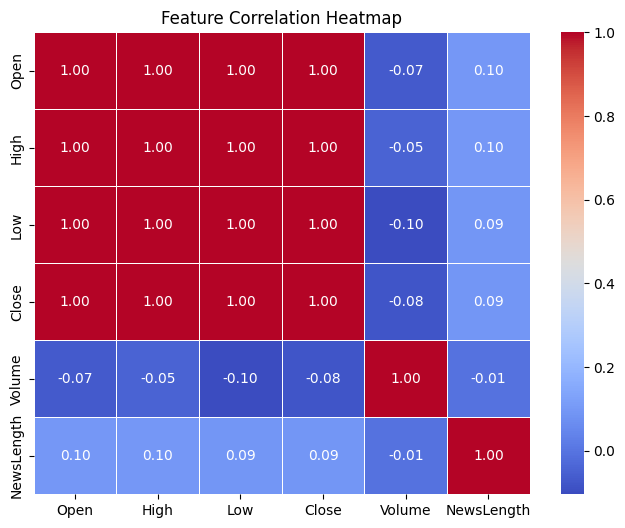

In [18]:
# Compute correlation matrix
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume', 'NewsLength']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap");

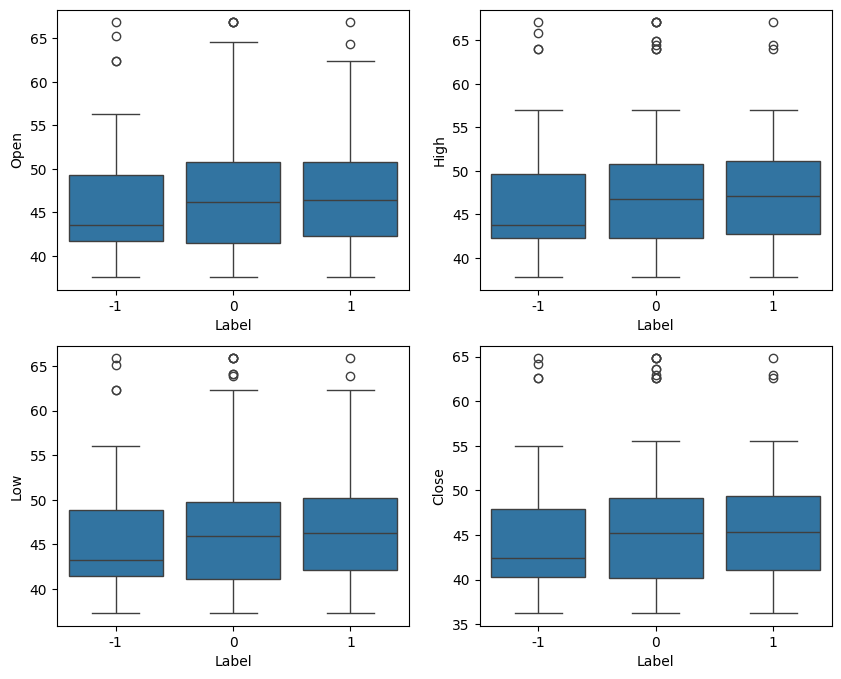

In [19]:
plt.figure(figsize=(10, 8))

for i, feature in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df, x="Label", y=feature)

plt.show();

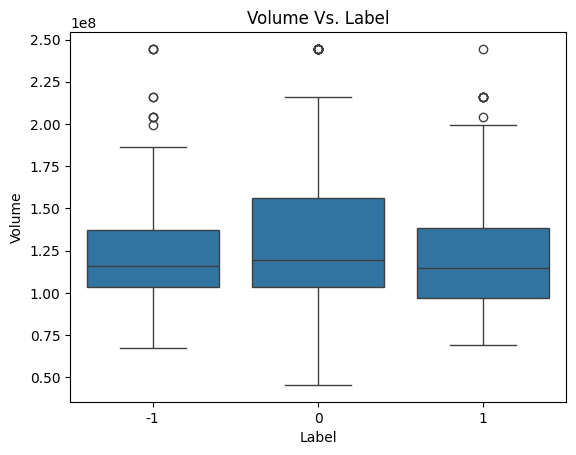

In [20]:
sns.boxplot(data=df, x="Label", y="Volume")
plt.title("Volume Vs. Label");

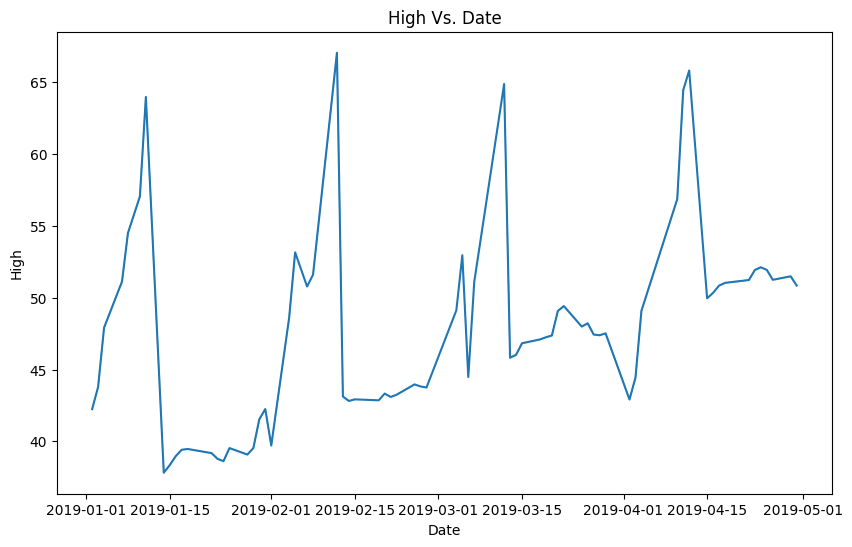

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Date", y="High")
plt.title("High Vs. Date");

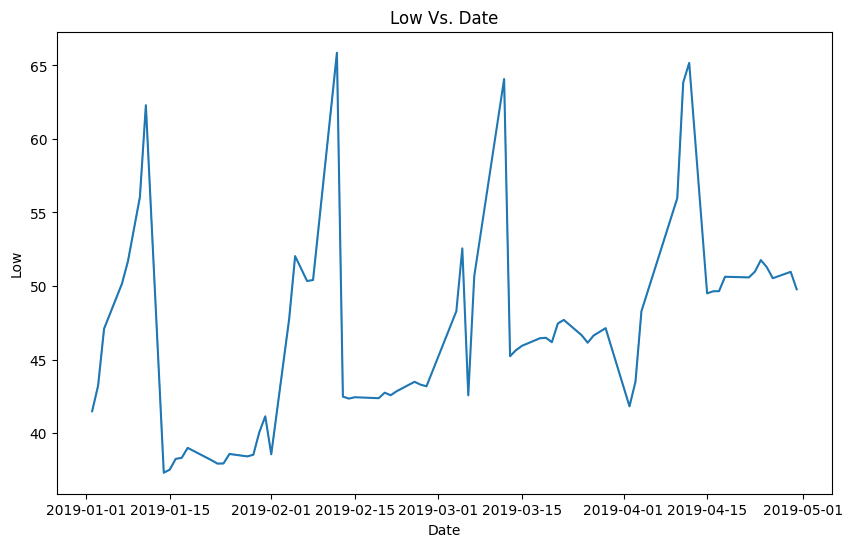

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Date", y="Low")
plt.title("Low Vs. Date");

In [23]:
# visualize average value per day
stock_daily_mean = df.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean'
    }
).reset_index()

stock_daily_mean.set_index('Date', inplace=True)
stock_daily_mean.head()

,Open,High,Low,Close
Date,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914
2019-01-03,43.570000,43.787498,43.222500,42.470604
2019-01-04,47.910000,47.919998,47.095001,46.419842
2019-01-07,50.792500,51.122501,50.162498,49.110790
2019-01-08,53.474998,54.507500,51.685001,50.787209


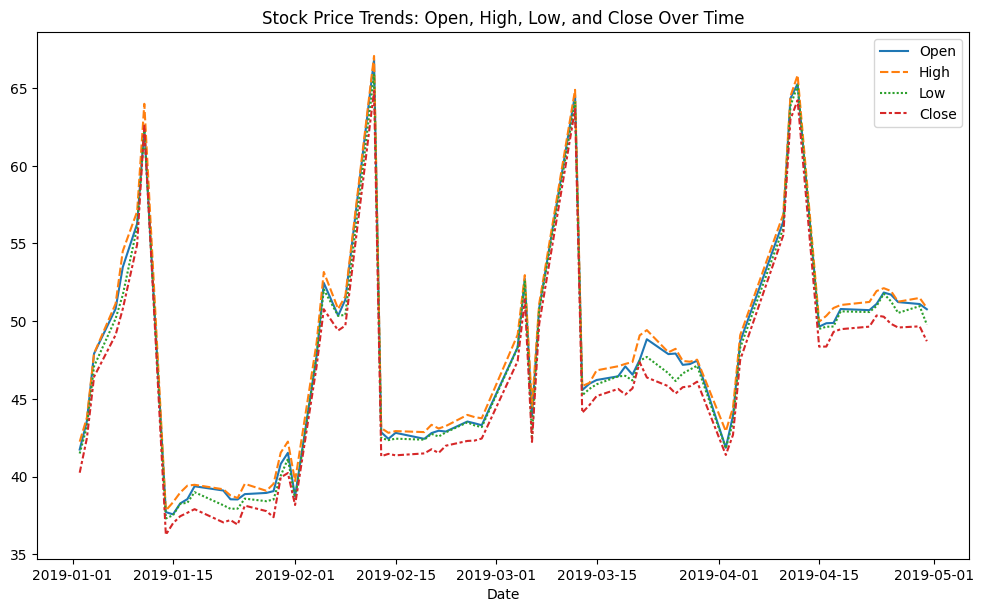

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(stock_daily_mean)
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title("Stock Price Trends: Open, High, Low, and Close Over Time");

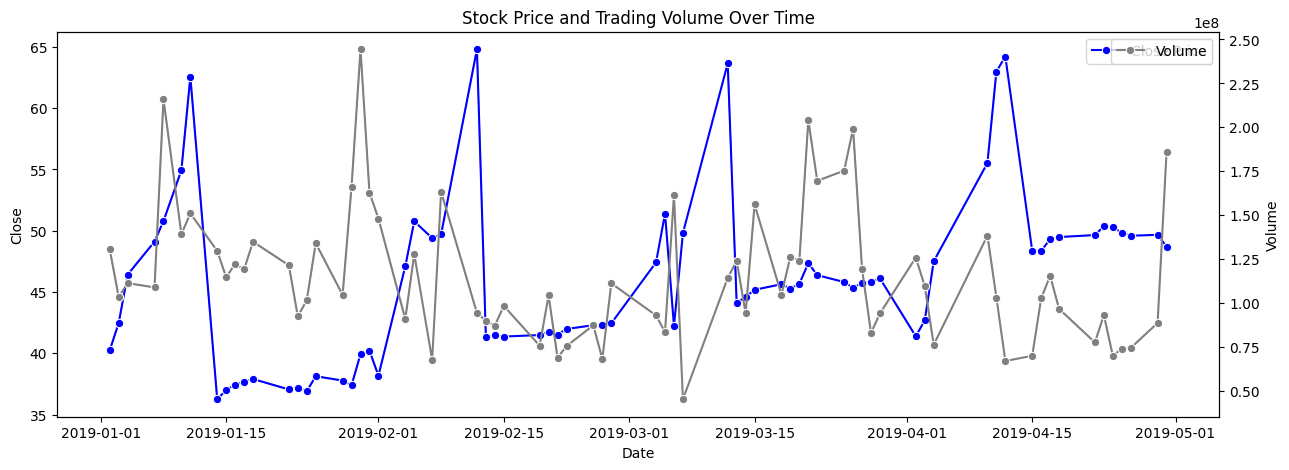

In [25]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))
plt.title("Stock Price and Trading Volume Over Time")

# Lineplot on primary y-axis
sns.lineplot(data=df.reset_index(),
             x='Date', y='Close',
             ax=ax1, color='blue',
             marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()
# Lineplot on secondary y-axis
sns.lineplot(data=df.reset_index(),
             x='Date', y='Volume',
             ax=ax2, color='gray',
             marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Data Preprocessing**

In [26]:
df.describe()

,Date,Open,High,Low,Close,Volume,Label,NewsLength
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441,49.312321
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000,19.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000,46.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000,50.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000,53.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000,61.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119,5.727770


In [27]:
#train-val-test split

X_train = df[(df['Date'] < '2019-04-01')].reset_index(drop=True)
X_val = df[(df['Date'] >= '2019-04-01') & (df['Date'] < '2019-04-16')].reset_index(drop=True)
X_test = df[df['Date'] >= '2019-04-16'].reset_index(drop=True)

y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [28]:
#drop Label and Date column from feature sets

X_train = X_train.drop(columns=['Date', 'Label'], axis=1)
X_val = X_val.drop(columns=['Date', 'Label'], axis=1)
X_test = X_test.drop(columns=['Date', 'Label'], axis=1)

In [29]:
#print the shape of train-val-test sets

print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 7)
Validation data shape (21, 7)
Test data shape  (42, 7)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        349 non-null    datetime64[ns]
 1   News        349 non-null    object        
 2   Open        349 non-null    float64       
 3   High        349 non-null    float64       
 4   Low         349 non-null    float64       
 5   Close       349 non-null    float64       
 6   Volume      349 non-null    int64         
 7   Label       349 non-null    int64         
 8   NewsLength  349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 24.7+ KB


## **Word Embeddings**

##### Word2Vec

In [31]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in df['News'].values]

In [32]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


In [33]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-4.14752495e-03,  3.74749936e-02,  8.24005064e-03,  1.16285011e-02,
        1.48537953e-03, -5.72237670e-02,  2.85559427e-02,  8.68466720e-02,
        3.69864679e-03, -2.18536202e-02,  6.01857528e-03, -2.09788475e-02,
       -4.62434394e-03,  1.50650367e-02, -2.53409855e-02, -2.69203708e-02,
        2.30138302e-02, -4.17288532e-03,  6.69978233e-03, -2.45450549e-02,
       -2.25735549e-02,  7.91398715e-03,  2.93304343e-02,  1.47854192e-02,
        2.43769027e-02,  6.33317512e-04, -3.51114944e-02,  8.68766475e-03,
       -2.87340842e-02, -4.09169830e-02,  9.67949722e-03, -2.73919702e-02,
        4.92364820e-03, -8.56969226e-03, -1.74074620e-03,  2.31959056e-02,
        1.23228785e-02, -3.39134224e-02, -2.35705334e-03, -1.19470786e-02,
       -2.01299544e-02,  3.70019954e-03, -2.33085702e-05, -2.04391573e-02,
        1.99547708e-02,  3.77485305e-02,  9.00161266e-03,  1.79117583e-02,
        2.80696433e-04,  2.36292407e-02,  1.20062428e-02, -9.01647191e-03,
       -2.07244121e-02,  

In [34]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [35]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [36]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.5107524394989014


In [37]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


##### GloVe

In [38]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [39]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [40]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [41]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [42]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [43]:
vec_size=100

# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  25.827239274978638


In [44]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


##### Sentence Transformer

In [45]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [46]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  0.8369855880737305


In [48]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

### Utility Functions

Comment on which metric to use and why?

In [49]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    # Plot the confusion matrix using a heatmap with annotations.
    plt.figure(figsize=(5, 4))
    label_list = [0, 1,-1]
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [50]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)

    # Compute metrics
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred,average='weighted')
    precision = precision_score(target, pred,average='weighted')
    f1 = f1_score(target, pred,average='weighted')

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf

### Base Models

##### Word2Vec

In [51]:
# Building the model

base_wv = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(random_state=42)

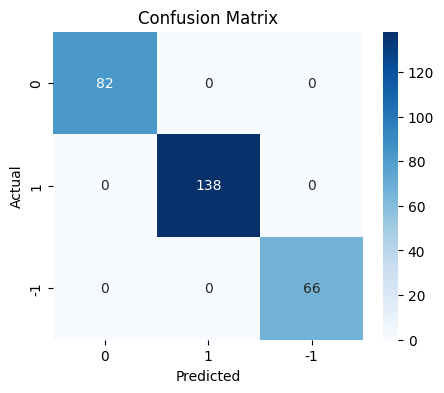

In [52]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

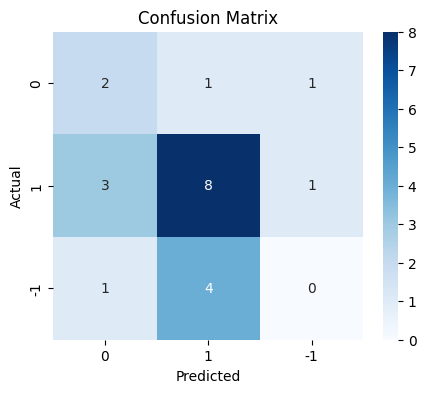

In [53]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [54]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [55]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619    0.41514  0.441905


##### GloVe

In [56]:
#Building the model

base_gl = RandomForestClassifier(random_state=42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=42)

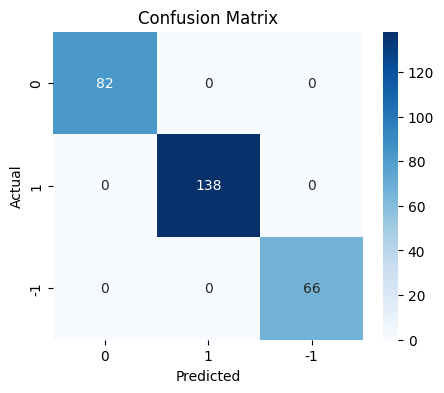

In [57]:
plot_confusion_matrix(base_gl,X_train_gl,y_train)

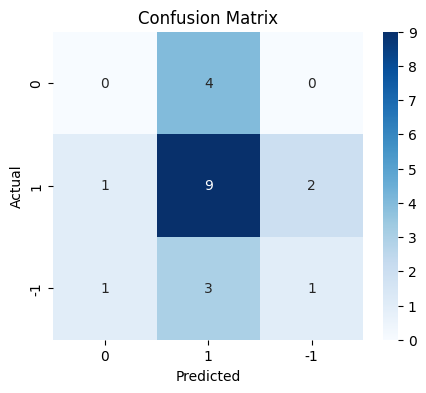

In [58]:
plot_confusion_matrix(base_gl,X_val_gl,y_val)

In [59]:
#Calculating different metrics on training data
base_train_gl = model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [60]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


##### Sentence Transformer

In [61]:
# Building the model

base_st = RandomForestClassifier(random_state=42)

# Fitting on train data
base_st.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

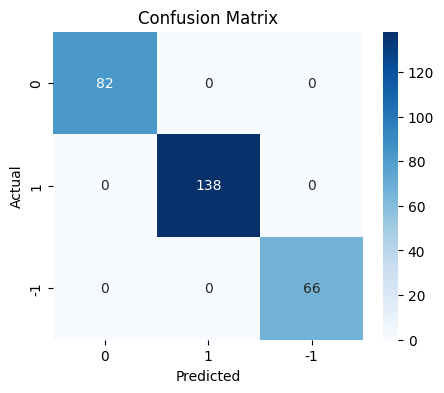

In [62]:
plot_confusion_matrix(base_st,X_train_st,y_train)

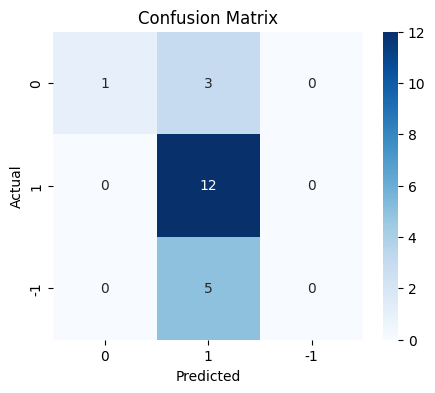

In [63]:
plot_confusion_matrix(base_st,X_val_st,y_val)

In [64]:
#Calculating different metrics on training data
base_train_st = model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [65]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048   0.533333  0.504762


### Hyperparameter Tuning



##### Word2Vec

In [66]:
start = time.time()

tuned_wv = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  90.13495564460754


In [67]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(max_depth=4, max_features=0.4, min_samples_split=9,
                           random_state=42)

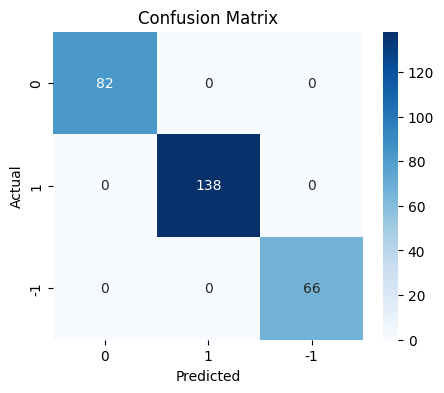

In [68]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

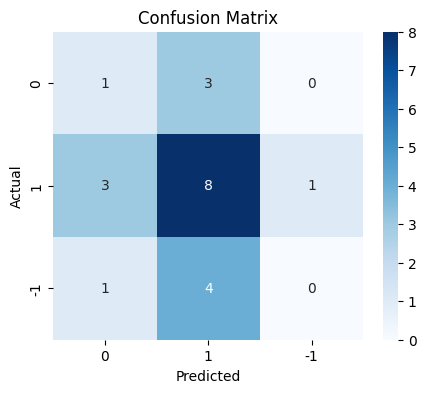

In [69]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [70]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [71]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.342857  0.380952


##### GloVe

In [72]:
start = time.time()

tuned_gl = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  12.765797853469849


In [73]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

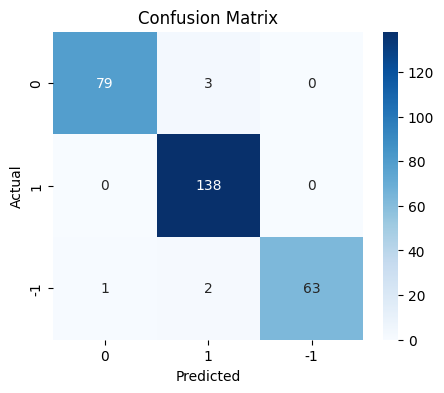

In [74]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

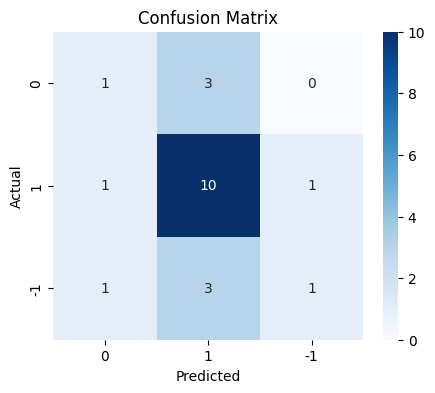

In [75]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [76]:
#Calculating different metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [77]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.539683  0.530612


##### Sentence Transformer

In [78]:
start = time.time()

# Choose the type of classifier.

tuned_st = RandomForestClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  26.129111528396606


In [79]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=11,
                       random_state=42)

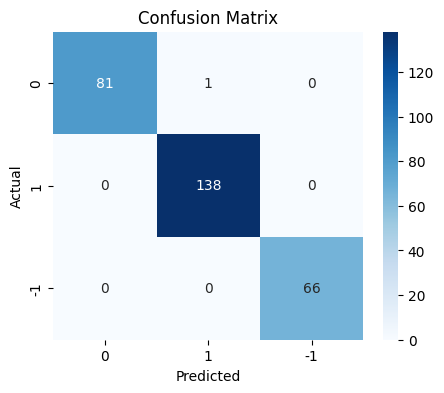

In [80]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

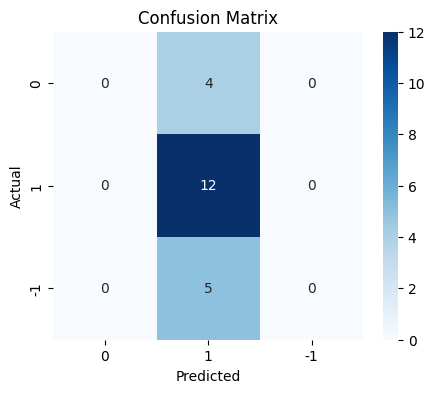

In [81]:
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [82]:
#Calculating different metrics on training data
tuned_train_st = model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996503  0.996503   0.996529  0.996499


In [83]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.326531  0.415584


### Model Performance Summary and Final Model Selection

The Base Model using Sentence Transformer is the best-performing model based on the metrics below. It correctly predicts the sentiment more often than the others. It effectively identifies relevant positive/negative instances and produces fewer false positives compared to others. The F1 Score of `~ 0.505` indicates the best balance between precision and recall.

While the Tuned GloVe model shows competitive performance in F1 score `~ 0.531` and Precision `~ 0.540`, its accuracy `~ 0.571` is lower than the Base Sentence Transformer.



In [84]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,1.0,0.979021,0.996503
Recall,1.0,1.0,1.0,1.0,0.979021,0.996503
Precision,1.0,1.0,1.0,1.0,0.979545,0.996529
F1,1.0,1.0,1.0,1.0,0.978968,0.996499


In [85]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.476190,0.476190,0.619048,0.428571,0.571429,0.571429
Recall,0.476190,0.476190,0.619048,0.428571,0.571429,0.571429
Precision,0.415140,0.400794,0.533333,0.342857,0.539683,0.326531
F1,0.441905,0.426871,0.504762,0.380952,0.530612,0.415584


### Model Performance Check on Test Data

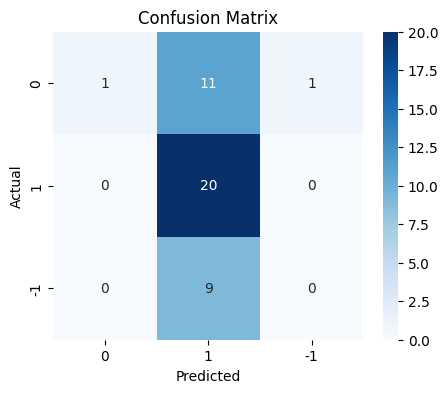

In [86]:
plot_confusion_matrix(base_st,X_test_st,y_test)

In [87]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(base_st,X_test_st,y_test)
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy  Recall  Precision        F1
0       0.5     0.5   0.547619  0.361678


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [88]:
# Installation for GPU llama-cpp-python
!pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 34.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.7-cp311-cp311-linux_x86_64.whl size=4599553 sha256=1fc7b81a444037b11a13a394ec5626aa18682d2ca0dcf7f4485d9cd951588f48
  Stored in directory: /root/.cache/pip/wheels/eb/82/79/ac77fcd49324b75ae6aa18e63a87cf9da4371a57e2cdc8dc03
Successfully built llama-cpp-python


In [89]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm 
tqdm.pandas()

#### Loading the data

In [90]:
data = stock_news.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


#### Loading the model

In [91]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [92]:
llm = Llama(
    model_path=model_path,
    n_gpu_layers=100,  #Number of layers transferred to GPU
    n_ctx=4500,  # Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [93]:
data["Date"] = pd.to_datetime(data['Date'])  

In [94]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [95]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [96]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [97]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

##### Utility Functions

In [98]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [99]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, 
      temperature=0, 
      top_p=0.95, 
      top_k=50, 
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

In [100]:
news = data_1.loc[0, 'News']

In [101]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [102]:
#defining a prompt 
prompt = """
    You are a financial AI assistant specializing in stock market news summarization.
    You will be provided with multiple news articles, each separated by ' || '.
    Carefully analyze each article for key insights.
    Identify the top three positive and negative aspects that could potentially impact the stock's performance.
    Consider factors such as market trends, company announcements, economic indicators, and any other relevant financial information.
    Return your response in valid JSON format as follows:
    {
      "Positive aspects": ["point_1", "point_2", "point_3"],
      "Negative aspects": ["point_1", "point_2", "point_3"]}
    }

    Only return the JSON output. Do not include any explanations or additional text.
"""

In [103]:
news = data['News'].iloc[0]

In [104]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

llama_perf_context_print:        load time =   26760.89 ms
llama_perf_context_print: prompt eval time =   26760.44 ms /   267 tokens (  100.23 ms per token,     9.98 tokens per second)
llama_perf_context_print:        eval time =   11305.54 ms /    68 runs   (  166.26 ms per token,     6.01 tokens per second)
llama_perf_context_print:       total time =   38100.11 ms /   335 tokens


 {
        "Positive aspects": [],
        "Negative aspects": ["Apple's Q1 revenue warning caused a significant decline in the tech sector", "Notable suppliers such as Skyworks, Broadcom, Lumentum, Qorvo, and TSMC saw their stocks drop in response"]
      }
CPU times: user 5min 52s, sys: 231 ms, total: 5min 53s
Wall time: 38.1 s


##### Checking the model output on the weekly data

In [105]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 259 prefix-match hit, remaining 3675 prompt tokens to eval
llama_perf_context_print:        load time =   26760.89 ms
llama_perf_context_print: prompt eval time =  297599.84 ms /  3675 tokens (   80.98 ms per token,    12.35 tokens per second)
llama_perf_context_print:        eval time =   47220.83 ms /   224 runs   (  210.81 ms per token,     4.74 tokens per second)
llama_perf_context_print:       total time =  344964.03 ms /  3899 tokens
 11%|█         | 2/18 [05:44<45:59, 172.49s/it]Llama.generate: 189 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =   26760.89 ms
llama_perf_context_print: prompt eval time =  171765.28 ms /  2234 tokens (   76.89 ms per token,    13.01 tokens per second)
llama_perf_context_print:        eval time =   67119.56 ms /   341 runs   (  196.83 ms per token,     5.08 tokens per second)
llama_perf_context_print:       total time =  239144.88 ms /  2575 to

CPU times: user 8h 56min 19s, sys: 14.8 s, total: 8h 56min 34s
Wall time: 58min 44s


In [106]:
data_1["Key Events"].head() 

,Key Events
0,"{\n ""Positive aspects"": [""Roku Inc's..."
1,"{\n ""Positive aspects"": [\n ""..."
2,"{\n ""Positive aspects"": [\n ..."
3,"{\n ""News Articles"": [\n ..."
4,"{\n ""News Articles"": [\n ..."


##### Formatting the model output

In [107]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

Error parsing JSON: Expecting ',' delimiter: line 62 column 14 (char 4490)
Error parsing JSON: Expecting ',' delimiter: line 82 column 11 (char 4275)
Error parsing JSON: Extra data: line 65 column 7 (char 2090)
Error parsing JSON: Expecting ',' delimiter: line 95 column 14 (char 4212)


,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""Positive aspects"": [""Roku Inc's...",{'Positive aspects': ['Roku Inc's plan to offe...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive aspects"": [\n ""...",{'Positive aspects': ['Sprint and Samsung plan...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive aspects"": [\n ...",{'Positive aspects': ['Dialog Semiconductor re...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""News Articles"": [\n ...",{}
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""News Articles"": [\n ...",{}


In [108]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive aspects,Negative aspects,News Articles Analysis
0,[Roku Inc's plan to offer premium video channe...,[Apple's Q1 revenue warning leading to signifi...,NaN
1,[Sprint and Samsung planning to release 5G sma...,[Geely forecasting flat sales for 2019 due to ...,NaN
2,[Dialog Semiconductor reported revenue in line...,[U.S. stock market declined on Monday due to c...,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [109]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events', 'News Articles Analysis']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events,News Articles Analysis
0,2019-01-06,The tech sector experienced a significant dec...,[Roku Inc's plan to offer premium video channe...,[Apple's Q1 revenue warning leading to signifi...,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[Sprint and Samsung planning to release 5G sma...,[Geely forecasting flat sales for 2019 due to ...,NaN
2,2019-01-20,The U.S. stock market declined on Monday as c...,[Dialog Semiconductor reported revenue in line...,[U.S. stock market declined on Monday due to c...,NaN
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",NaN,NaN,NaN
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,NaN,NaN,NaN


## **Conclusions and Recommendations**

#### Insights from Visualizations:

- Line plots of Open, High, Low, and Close prices show daily fluctuations.
- The dual-axis line plot illustrates the relationship between closing price and trading volume. Sudden spikes in volume often coincide with sharp price movements.
- The countplot shows a higher frequency of neutral sentiments, which could indicate that most news articles are unbiased.

#### Business Recommendations:
- Leverage Sentiment Trends for Market Predictions: Use historical sentiment vs. price movement to develop early warning signals for trading decisions.

- Monitor Volume Spikes: Large trading volumes following sentiment changes can help validate news-driven stock movements.

<font size=6 color='blue'>Power Ahead</font>
___